# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [2]:
% matplotlib inline
% pprint off

### import the libraries you think its necessary for your task 
# Matplotlib library
import matplotlib.pyplot as plt
from matplotlib import cm

# Numpy library
import numpy as np

from skimage import io
from skimage.color import rgb2grey

from skimage import exposure

from skimage import img_as_ubyte
from skimage import img_as_float
from skimage import img_as_uint



Pretty printing has been turned OFF


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [3]:
def cont_str(sat_img_float):
    max_im = sat_img_float.max()
    min_im = sat_img_float.min()
    l,b=sat_img_float.shape
    sat_img_cont_str = np.zeros((sat_img_float.shape))
    for i in range(l):
        for j in range(b):
            sat_img_cont_str[i][j] = (sat_img_float[i][j]-min_im)/(max_im-min_im)
    return sat_img_cont_str


**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

/home/spark/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


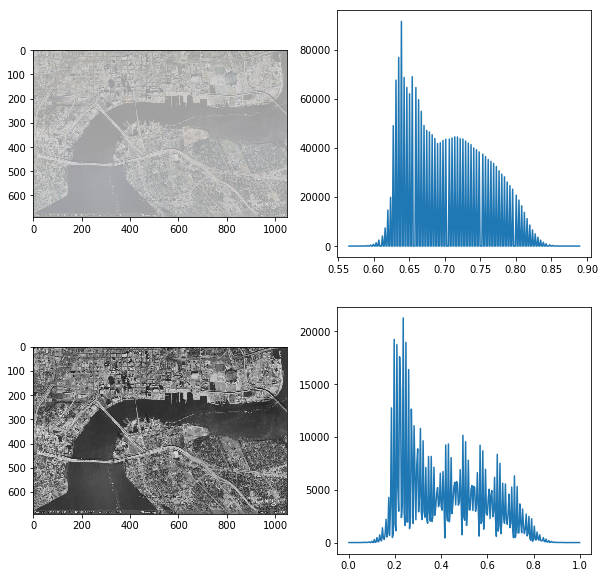

In [7]:
img_path='./images/'
img_name2='satellite.jpg'
satellite = io.imread(img_path.__add__(img_name2))
sat_img_float = img_as_float(satellite)
sat_img_float1 = rgb2grey(sat_img_float)
sat_img_cont_str = cont_str(sat_img_float1)

fig, axes = plt.subplots(2,2, figsize=(10, 10))
axes = axes.ravel()

exposure_bins, center_exposure = exposure.histogram(sat_img_float,256)
axes[0].imshow(sat_img_float,cmap = cm.gray)
axes[1].plot(center_exposure,exposure_bins)

# Plot the transform function
exposure_bins, center_exposure = exposure.histogram(sat_img_cont_str,256)
axes[2].imshow(sat_img_cont_str1,cmap = cm.gray)
axes[3].plot(center_exposure,exposure_bins)

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

In [41]:
sat_img_float.dtype

dtype('float64')

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [8]:
def hist_eq(img,max_int,min_int):
    img_sat_ubyte = img_as_ubyte(img)
    l,b=img_sat_ubyte.shape
    new_image= np.zeros((l,b))
    h = np.zeros((256,1))
    for i in range(l):
        for j in range(b):
            h[img_sat_ubyte[i][j]] = h[img_sat_ubyte[i][j]] + 1
    hn = h/h.sum()
    c = np.zeros((256,1))
    for i in range(255):
        c[i] = hn[0:i].sum()
    g = np.zeros((256,1))
    for i in range(255):
        g[i] = 255*c[i]
    for i in range(l):
        for j in range(b):
            new_image[i][j] = g[img_sat_ubyte[i][j]]
    return (new_image.astype('uint8'), c)

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [9]:
img_path='./images/'
img_name2='satellite.jpg'
satellite = io.imread(img_path.__add__(img_name2),as_grey=True)
new_image, c = hist_eq(satellite,255,0)

/home/spark/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


**Show the transformed image and its histogram**

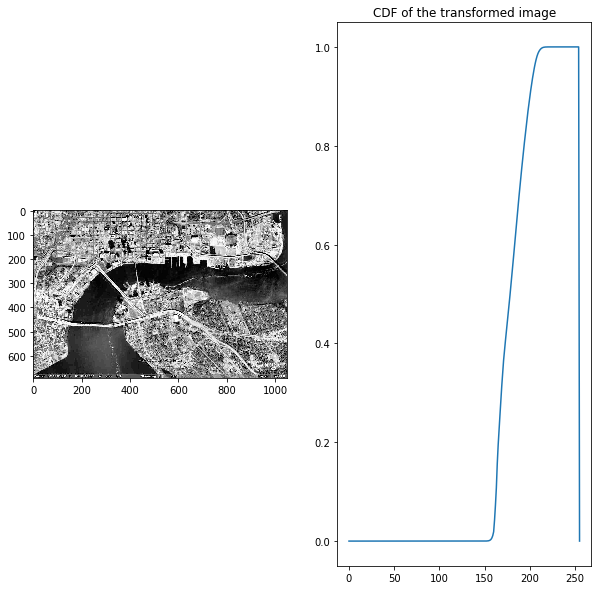

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10, 10))
axes = axes.ravel()
axes[0].imshow(new_image,cmap = cm.gray)
axes[1].plot(c)
plt.title('CDF of the transformed image')

### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

The process of Histogram Matching takes in an input image and produces an output image that is based upon a specified histogram. The required parameters for this algorithm are the input image and the specified image, from which the specified histogram can be obtained.

In [13]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [14]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

In [15]:
from scipy.stats import norm
max_img=np.amax(new_image)
x = np.arange(255+1)
pdf_to_fit = norm.pdf(x, 150, 30)

**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

/home/spark/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


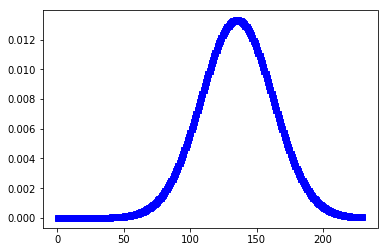

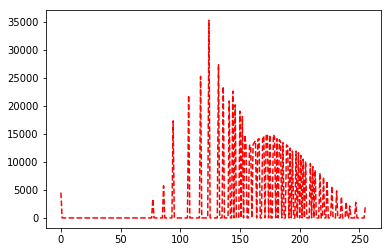

In [40]:
max_int = 255 
min_int = 0
image = hist_match(satellite, pdf_to_fit, min_int, max_int)
exposure_bins, center_exposure = exposure.histogram(image,256)

#plt.plot(center_exposure,pdf_to_fit, 'bs', center_exposure,exposure_bins, 'r--')
plt.plot(center_exposure,pdf_to_fit, 'bs')

plt.show()

plt.plot(exposure_bins, 'r--')
plt.show()
#image_match = hist_match(new_img, pdf_to_fit, min_int, max_int)

### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


This transformation maps a narrow range of low-level grey scale intensities into a wider range of output values. And similarly maps the wide range of high-level grey scale intensities into a narrow range of high level output values.

** Explain how sigmoid function enhances the image **

Sigmoid function is a continuous nonlinear activation functionwhich is $"S"$ shaped. The sigmoid function has the characteristics that it is a smooth continuous function so can be used to enhance both darker and brigher side of image. 